<a href="https://colab.research.google.com/github/eminshall/Notebooks-Youtube-Channel/blob/main/Crypto_Market_Inefficiency_Based_on_Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import yfinance as yf
from datetime import datetime, date
import datetime

In [ ]:
portfolio = ['BTC-USD','ETH-USD','XRP-USD','USDT-USD','SOL-USD','BNB-USD','DOGE-USD']

end = date.today()
start = end - datetime.timedelta(days = 7*365)

data = yf.download(portfolio, start, end, group_by='Ticker' )

data.head()

[*********************100%***********************]  7 of 7 completed


Ticker          BTC-USD                                                     \
Price              Open         High          Low        Close      Volume   
Date                                                                         
2018-02-10  8720.080078  9122.549805  8295.469727  8621.900391  7780960256   
2018-02-11  8616.129883  8616.129883  7931.100098  8129.970215  6122189824   
2018-02-12  8141.430176  8985.919922  8141.430176  8926.570312  6256439808   
2018-02-13  8926.719727  8958.469727  8455.410156  8598.309570  5696719872   
2018-02-14  8599.919922  9518.540039  8599.919922  9494.629883  7909819904   

Ticker      DOGE-USD                                          ...  USDT-USD  \
Price           Open      High       Low     Close    Volume  ...      Open   
Date                                                          ...             
2018-02-10  0.004982  0.005441  0.004744  0.004989  16717300  ...  1.003480   
2018-02-11  0.004968  0.005183  0.004606  0.004956  11309800  ...  1.004920   
2018-02-12  0.004964  0.005508  0.004964  0.005472  11124300  ...  1.000210   
2018-02-13  0.005475  0.005678  0.005271  0.005638  14149700  ...  1.000800   
2018-02-14  0.005630  0.006786  0.005630  0.006730  40527400  ...  0.997715   

Ticker                                                  ETH-USD              \
Price          High       Low     Close      Volume        Open        High   
Date                                                                          
2018-02-10  1.01495  0.993346  1.003700  2628379904  882.466980  917.400024   
2018-02-11  1.01252  0.992728  0.999251  2431739904  859.288025  859.288025   
2018-02-12  1.00796  0.990812  1.000090  2457489920  817.507996  875.937012   
2018-02-13  1.00865  0.995931  1.001100  2226759936  869.293030  870.708984   
2018-02-14  1.00681  0.993292  1.000770  3066190080  844.278992  926.429016   

Ticker                                          
Price              Low       Close      Volume  
Date                                            
2018-02-10  825.577026  860.414978  2930530048  
2018-02-11  788.221985  814.659973  2486650112  
2018-02-12  817.507996  868.706970  2243450112  
2018-02-13  828.836975  845.257996  2081170048  
2018-02-14  844.278992  923.560974  2818370048  

[5 rows x 35 columns]

In [ ]:
df = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
df.set_index('Ticker', append=True, inplace=True)
df = df.reorder_levels(['Ticker', 'Date']).sort_index()
df.drop_duplicates(inplace=True)
df.head()

<ipython-input-3-e1e5bba9875d>:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)


Price                  Open      High      Low     Close      Volume
Ticker  Date                                                        
BNB-USD 2018-02-10  9.73273  10.36320  8.84852   9.25597  80123200.0
        2018-02-11  9.20087   9.34548  8.14445   8.70491  68554600.0
        2018-02-12  8.71145   9.40375  8.71145   9.32247  50792600.0
        2018-02-13  9.31767   9.34794  8.77337   8.98678  41593400.0
        2018-02-14  9.01591  10.64980  8.99024  10.40060  68781600.0

In [ ]:
def parkinson(data, window=14, trading_days=252):
  rs = (1.0 / 4.0 * np.log(2.0))* ((
      data.High / data.Low).apply(np.log)) **2.0
  def f(v):
      return (trading_days * v.mean())**0.5
  result = rs.rolling(
          window=window,
          center=False
  ).apply(func=f)
  return result.sub(result.mean()).div(result.std())

In [ ]:
df['vol'] = (
    df.groupby('Ticker', group_keys=False)
    .apply(parkinson)
)
df.sample()

,Price,Open,High,Low,Close,Volume,vol
Ticker,Date,,,,,,
XRP-USD,2024-05-08,0.524744,0.52906,0.515715,0.51723,1.122169e+09,-0.65519


In [ ]:
lags = [1,5,10,21,42,63]
for lag in lags:
  df[f'return_{lag}d'] = (
      df.groupby(level='Ticker')
      .Close
      .pct_change(lag)
  )

df

Price                   Open       High       Low      Close        Volume  \
Ticker  Date                                                                 
BNB-USD 2018-02-10  9.732730  10.363200  8.848520   9.255970  8.012320e+07   
        2018-02-11  9.200870   9.345480  8.144450   8.704910  6.855460e+07   
        2018-02-12  8.711450   9.403750  8.711450   9.322470  5.079260e+07   
        2018-02-13  9.317670   9.347940  8.773370   8.986780  4.159340e+07   
        2018-02-14  9.015910  10.649800  8.990240  10.400600  6.878160e+07   
...                      ...        ...       ...        ...           ...   
XRP-USD 2025-02-03  2.579795   2.779850  1.948621   2.701156  3.674510e+10   
        2025-02-04  2.701309   2.776645  2.435540   2.535425  1.415454e+10   
        2025-02-05  2.535369   2.567157  2.356648   2.382315  7.724989e+09   
        2025-02-06  2.382258   2.464688  2.292329   2.326880  7.292153e+09   
        2025-02-07  2.326896   2.533868  2.283990   2.393583  9.288665e+09   

Price                    vol  return_1d  return_5d  return_10d  return_21d  \
Ticker  Date                                                                 
BNB-USD 2018-02-10       NaN        NaN        NaN         NaN         NaN   
        2018-02-11       NaN  -0.059536        NaN         NaN         NaN   
        2018-02-12       NaN   0.070944        NaN         NaN         NaN   
        2018-02-13       NaN  -0.036009        NaN         NaN         NaN   
        2018-02-14       NaN   0.157322        NaN         NaN         NaN   
...                      ...        ...        ...         ...         ...   
XRP-USD 2025-02-03  0.972207   0.047043  -0.119655   -0.129637    0.070640   
        2025-02-04  1.053020  -0.061356  -0.190237   -0.184674   -0.050094   
        2025-02-05  1.088984  -0.060388  -0.215161   -0.212777   -0.244922   
        2025-02-06  1.109587  -0.023269  -0.193307   -0.237884   -0.283053   
        2025-02-07  1.162866   0.028666  -0.072181   -0.218070   -0.274372   

Price               return_42d  return_63d  
Ticker  Date                                
BNB-USD 2018-02-10         NaN         NaN  
        2018-02-11         NaN         NaN  
        2018-02-12         NaN         NaN  
        2018-02-13         NaN         NaN  
        2018-02-14         NaN         NaN  
...                        ...         ...  
XRP-USD 2025-02-03    0.196651   -0.004661  
        2025-02-04    0.090682    0.003919  
        2025-02-05    0.037607    0.011838  
        2025-02-06    0.080090    0.013800  
        2025-02-07    0.117635   -0.012848  

[17095 rows x 12 columns]

In [ ]:
targets = [1,5,10,21,42,63]
for t in targets:
  df[f'target_{t}d'] = (
      df.groupby(level='Ticker')[f'return_{t}d']
      .shift(-t)
  )

df

Price                   Open       High       Low      Close        Volume  \
Ticker  Date                                                                 
BNB-USD 2018-02-10  9.732730  10.363200  8.848520   9.255970  8.012320e+07   
        2018-02-11  9.200870   9.345480  8.144450   8.704910  6.855460e+07   
        2018-02-12  8.711450   9.403750  8.711450   9.322470  5.079260e+07   
        2018-02-13  9.317670   9.347940  8.773370   8.986780  4.159340e+07   
        2018-02-14  9.015910  10.649800  8.990240  10.400600  6.878160e+07   
...                      ...        ...       ...        ...           ...   
XRP-USD 2025-02-03  2.579795   2.779850  1.948621   2.701156  3.674510e+10   
        2025-02-04  2.701309   2.776645  2.435540   2.535425  1.415454e+10   
        2025-02-05  2.535369   2.567157  2.356648   2.382315  7.724989e+09   
        2025-02-06  2.382258   2.464688  2.292329   2.326880  7.292153e+09   
        2025-02-07  2.326896   2.533868  2.283990   2.393583  9.288665e+09   

Price                    vol  return_1d  return_5d  return_10d  return_21d  \
Ticker  Date                                                                 
BNB-USD 2018-02-10       NaN        NaN        NaN         NaN         NaN   
        2018-02-11       NaN  -0.059536        NaN         NaN         NaN   
        2018-02-12       NaN   0.070944        NaN         NaN         NaN   
        2018-02-13       NaN  -0.036009        NaN         NaN         NaN   
        2018-02-14       NaN   0.157322        NaN         NaN         NaN   
...                      ...        ...        ...         ...         ...   
XRP-USD 2025-02-03  0.972207   0.047043  -0.119655   -0.129637    0.070640   
        2025-02-04  1.053020  -0.061356  -0.190237   -0.184674   -0.050094   
        2025-02-05  1.088984  -0.060388  -0.215161   -0.212777   -0.244922   
        2025-02-06  1.109587  -0.023269  -0.193307   -0.237884   -0.283053   
        2025-02-07  1.162866   0.028666  -0.072181   -0.218070   -0.274372   

Price               return_42d  return_63d  target_1d  target_5d  target_10d  \
Ticker  Date                                                                   
BNB-USD 2018-02-10         NaN         NaN  -0.059536   0.180978    0.070067   
        2018-02-11         NaN         NaN   0.070944   0.286814    0.077643   
        2018-02-12         NaN         NaN  -0.036009   0.253884   -0.044885   
        2018-02-13         NaN         NaN   0.157322   0.190905    0.078485   
        2018-02-14         NaN         NaN   0.051007   0.064910   -0.121021   
...                        ...         ...        ...        ...         ...   
XRP-USD 2025-02-03    0.196651   -0.004661  -0.061356        NaN         NaN   
        2025-02-04    0.090682    0.003919  -0.060388        NaN         NaN   
        2025-02-05    0.037607    0.011838  -0.023269        NaN         NaN   
        2025-02-06    0.080090    0.013800   0.028666        NaN         NaN   
        2025-02-07    0.117635   -0.012848        NaN        NaN         NaN   

Price               target_21d  target_42d  target_63d  
Ticker  Date                                            
BNB-USD 2018-02-10    0.103925    0.414125    0.430904  
        2018-02-11    0.188766    0.468493    0.500165  
        2018-02-12    0.084530    0.293799    0.309739  
        2018-02-13    0.044243    0.280581    0.309635  
        2018-02-14   -0.131312    0.119205    0.180288  
...                        ...         ...         ...  
XRP-USD 2025-02-03         NaN         NaN         NaN  
        2025-02-04         NaN         NaN         NaN  
        2025-02-05         NaN         NaN         NaN  
        2025-02-06         NaN         NaN         NaN  
        2025-02-07         NaN         NaN         NaN  

[17095 rows x 18 columns]

Spearman correlation: 0.009


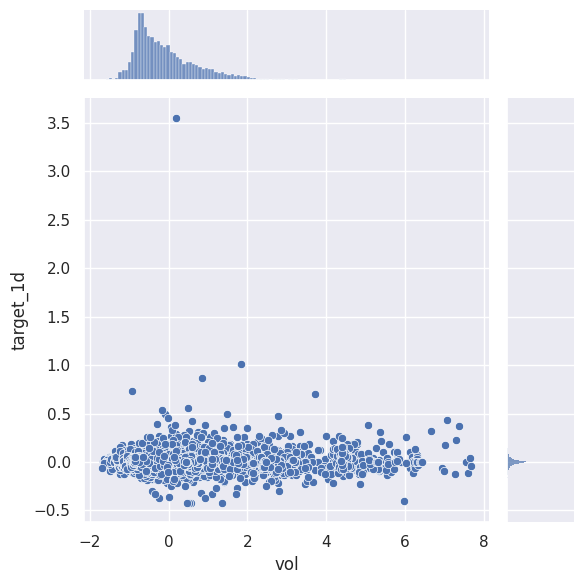

In [ ]:
target = 'target_1d'
metric = 'vol'
j = sns.jointplot(x=metric, y=target, data=df)
plt.tight_layout()
df1 = df[[metric, target]].dropna()
r, p = spearmanr(df1[metric], df1[target])
print(f'Spearman correlation: {r:.3f}')

Spearman correlation: -0.030


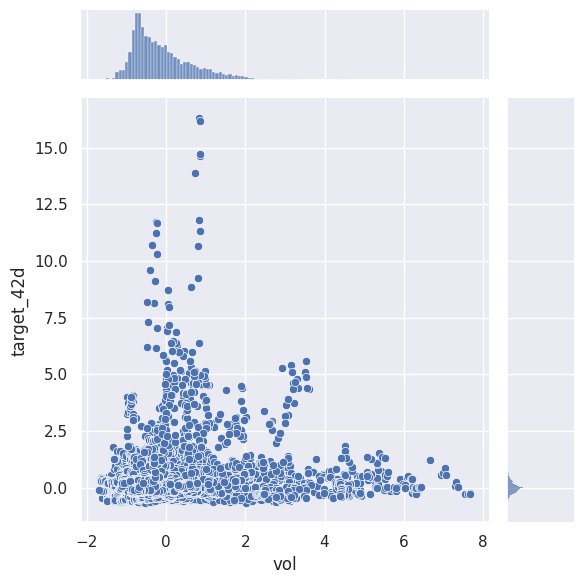

In [ ]:
target = 'target_42d'
metric = 'vol'
j = sns.jointplot(x=metric, y=target, data=df)
plt.tight_layout()
df1 = df[[metric, target]].dropna()
r, p = spearmanr(df1[metric], df1[target])
print(f'Spearman correlation: {r:.3f}')

#Consider Supporting Me

Making theses videos takes time and effort. Contributions from viewers like you help support my channel and avoid the need for promoting a Patreon, sponsors, or selling a course. Click the link and choose any amount you'd like. Thank you.

https://ko-fi.com/minshallsfi